In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os, random
from tqdm.auto import tqdm, trange

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, callbacks, utils

In [2]:
class config():
    IMG_SIZE = (128, 128) 
    
    EPOCHS = 500
    BATCH_SIZE = 16

In [3]:
def load_gry(img_path, img_size=config.IMG_SIZE):
    return cv2.resize(cv2.imread(img_path, 0), config.IMG_SIZE)

def load_rgb(img_path, img_size=config.IMG_SIZE):
    return cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), dsize=config.IMG_SIZE)

In [4]:
img_paths = []
dirs = ['../input/best-artworks-of-all-time/resized']
for directory in dirs:
    for class_label in os.listdir(directory):
        for img in os.listdir(os.path.join(directory, class_label)):
            img_paths.append(os.path.join(directory, class_label, img))
        
len(img_paths)     

8683

In [5]:
%%time
imgs_gry = np.array([load_gry(file_path) for file_path in tqdm(img_paths)])
imgs_rgb = np.array([load_rgb(file_path) for file_path in tqdm(img_paths)])


CPU times: user 1min 21s, sys: 9.25 s, total: 1min 30s
Wall time: 3min 55s


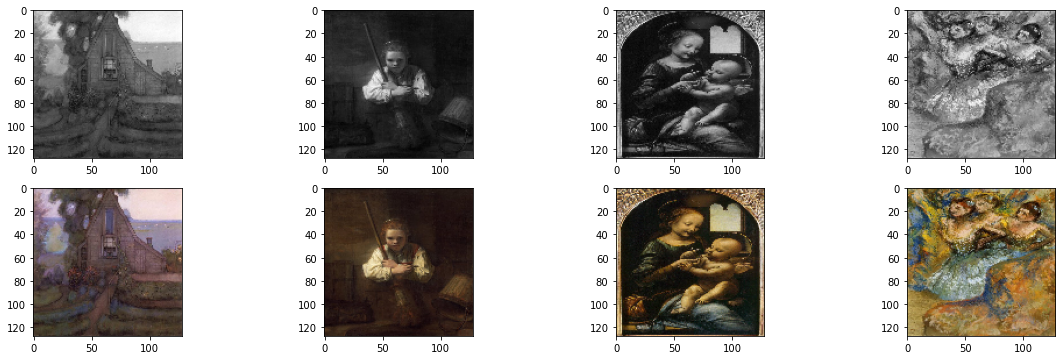

In [6]:
random.seed(19)
idx_to_plot = random.choices(range(len(img_paths)), k=4)

fig, ax = plt.subplots(2, 4, figsize=(20, 6))
for i, j in enumerate(idx_to_plot):
    ax[0][i].imshow(imgs_gry[j], cmap='gray')
    ax[1][i].imshow(imgs_rgb[j])

In [7]:
imgs_gry = np.expand_dims(imgs_gry, axis=-1)
imgs_gry = imgs_gry.astype(float)/255
imgs_rgb = imgs_rgb.astype(float)/255

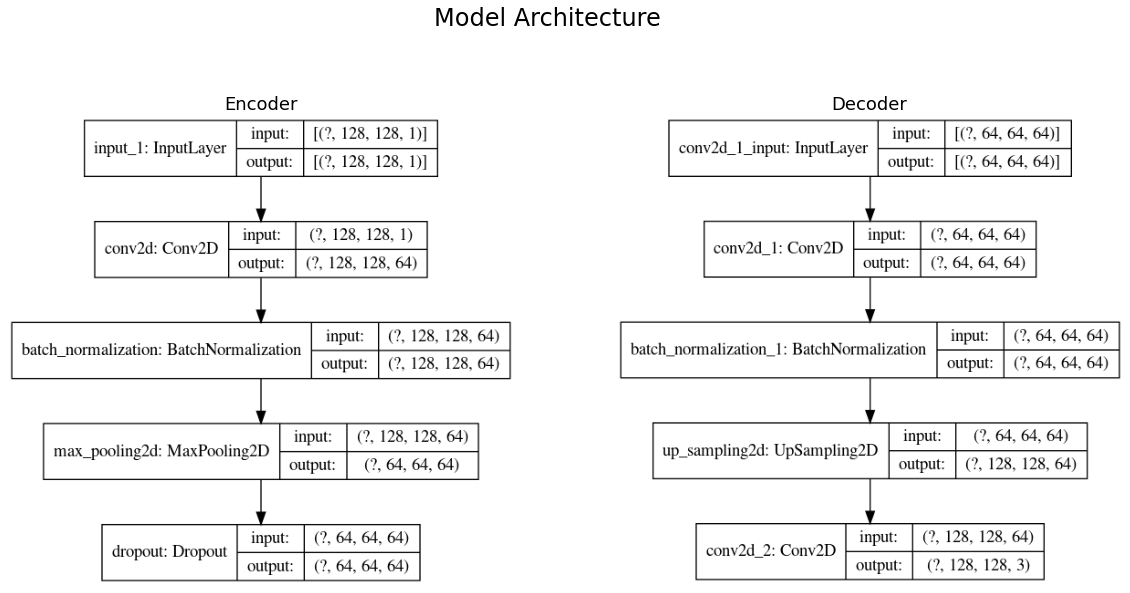

In [8]:
class ColorizingAutoencoder(Model):
    def __init__(self):
        super(ColorizingAutoencoder, self).__init__()
        self.encoder = Sequential([
            layers.Input(shape=(*config.IMG_SIZE, 1)), 
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.5),
        ])

        self.decoder = Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (1, 1), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ColorizingAutoencoder()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.build(input_shape=(None, *config.IMG_SIZE, 1))

utils.plot_model(model.encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')
utils.plot_model(model.decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(plt.imread('encoder.png')); ax[0].axis('off'); ax[0].set_title('Encoder', fontsize=18)
ax[1].imshow(plt.imread('decoder.png')); ax[1].axis('off'); ax[1].set_title('Decoder', fontsize=18)
fig.suptitle('Model Architecture', fontsize=24);

In [9]:
es = callbacks.EarlyStopping(
    monitor='val_loss', patience=30, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, mode='min', verbose=1
)


history =  model.fit(
    imgs_gry, imgs_rgb, validation_split=0.1,  
    callbacks=[es, rlp], epochs=config.EPOCHS, batch_size=config.BATCH_SIZE
)

Epoch 1/500
489/489 [==============================] - 8s 16ms/step - loss: 0.0179 - mean_absolute_error: 0.0976 - val_loss: 0.0230 - val_mean_absolute_error: 0.1251
Epoch 2/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0152 - mean_absolute_error: 0.0901 - val_loss: 0.0143 - val_mean_absolute_error: 0.0838
Epoch 3/500
489/489 [==============================] - 8s 15ms/step - loss: 0.0151 - mean_absolute_error: 0.0898 - val_loss: 0.0129 - val_mean_absolute_error: 0.0805
Epoch 4/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0152 - mean_absolute_error: 0.0899 - val_loss: 0.0129 - val_mean_absolute_error: 0.0799
Epoch 5/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0888 - val_loss: 0.0132 - val_mean_absolute_error: 0.0817
Epoch 6/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0891 - val_loss: 0.0128 - val_mean_absolute_error: 0.0792
Epoc

Epoch 46/500
489/489 [==============================] - 8s 15ms/step - loss: 0.0146 - mean_absolute_error: 0.0879 - val_loss: 0.0126 - val_mean_absolute_error: 0.0784
Epoch 47/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0144 - mean_absolute_error: 0.0874 - val_loss: 0.0126 - val_mean_absolute_error: 0.0784
Epoch 48/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0146 - mean_absolute_error: 0.0882 - val_loss: 0.0126 - val_mean_absolute_error: 0.0784
Epoch 49/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0145 - mean_absolute_error: 0.0879 - val_loss: 0.0126 - val_mean_absolute_error: 0.0783
Epoch 50/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0144 - mean_absolute_error: 0.0875 - val_loss: 0.0126 - val_mean_absolute_error: 0.0784
Epoch 51/500
489/489 [==============================] - 7s 15ms/step - loss: 0.0145 - mean_absolute_error: 0.0876 - val_loss: 0.0126 - val_mean_absolute_error: 0.078

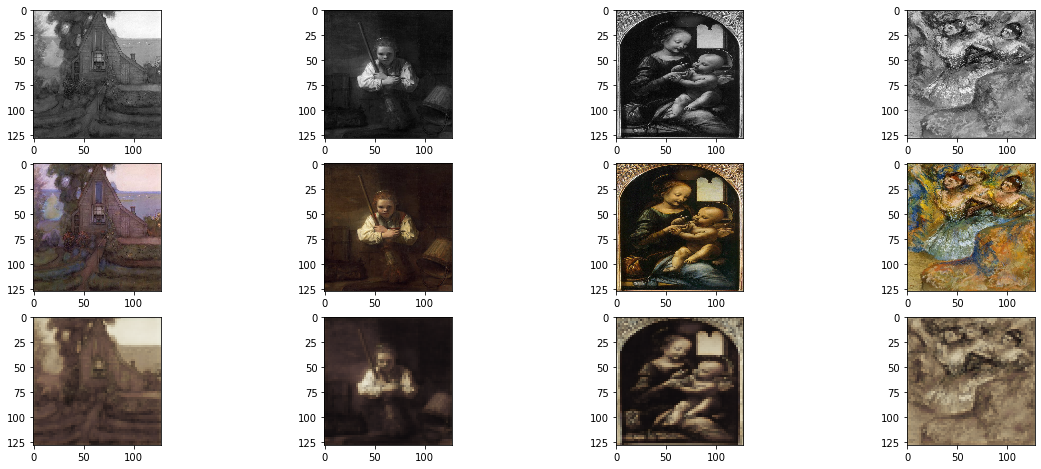

In [10]:
imgs_prd = model.predict(imgs_gry, batch_size=config.BATCH_SIZE)

fig, ax = plt.subplots(3, 4, figsize=(20, 8))
for i, j in enumerate(idx_to_plot):
    ax[0][i].imshow(np.squeeze(imgs_gry[j]), cmap='gray')
    ax[1][i].imshow(imgs_rgb[j])
    ax[2][i].imshow(imgs_prd[j])

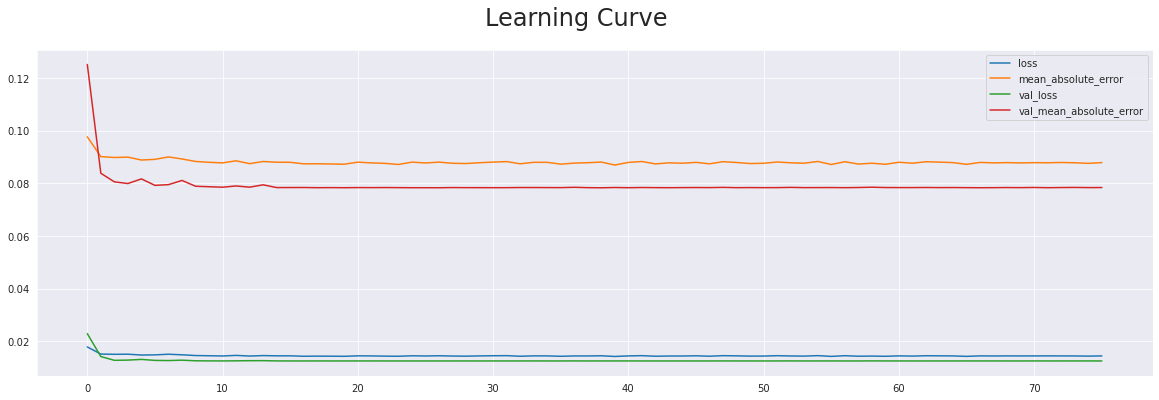

In [11]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).iloc[:, :-1].plot(ax=ax)
fig.suptitle('Learning Curve', fontsize=24);